# Solving the Flexible Job-Shop Scheduling Problem (FJSP)

The following notebook explains the FJSP and explains the solution construction process using an encoder-decoder architecture based on a Heterogeneous Graph Neural Network (HetGNN)

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/other/2-scheduling.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

In [21]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import time
import networkx as nx
import matplotlib.pyplot as plt
from rl4co.envs import FJSPEnv, FFSPEnv
from rl4co.models.zoo.hetgnn import HetGNNModel
from rl4co.models.zoo.hetgnn.policy import HetGNNPolicy
from rl4co.models.zoo.hetgnn.encoder import HetGNNEncoder
from rl4co.models.zoo.hetgnn.decoder import HetGNNDecoder
from rl4co.utils.trainer import RL4COTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
generator_params = {
  "num_jobs": 5,  # the total number of jobs
  "num_machines": 5,  # the total number of machines that can process operations
  "min_ops_per_job": 1,  # minimum number of operatios per job
  "max_ops_per_job": 2,  # maximum number of operations per job
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 20,  # the maximum time required for a machine to process an operation
  "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
  "max_eligible_ma_per_op": 3,  # the maximum number of machines capable to process an operation
}

In [23]:
env = FJSPEnv(generator_params=generator_params)
td = env.reset(batch_size=[1])

## Visualize the Problem

Below we visualize the generated instance of the FJSP. Blue nodes correspond to machines, red nodes to operations and yellow nodes to jobs. A machine may process an operation if there exists an edge between the two. 

The thickness of the connection between a machine and an operation node specifies the processing time the respective machine needs to process the operation (thicker line := longer processing).

Each operation belongs to exactly one job, where an edge between a job and an operation node indicates that the respective operation belongs to the job. The number above an operation-job edge specifies the precedence-order in which the operations of a job need to be processed. A job is done when all operations belonging to it are scheduled. The instance is solved when all jobs are fully scheduled.

Also note that some operation nodes are not connected. These operation nodes are padded, so that all instances in a batch have the same number of operations (where we determine the maximum number of operations as num_jobs * max_ops_per_job). 

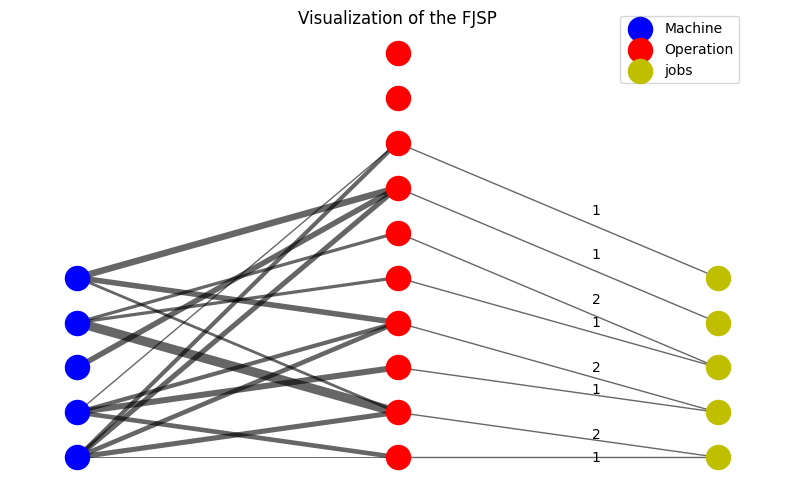

In [24]:
# Create a bipartite graph from the adjacency matrix
G = nx.Graph()
proc_times = td["proc_times"].squeeze(0)
job_ops_adj = td["job_ops_adj"].squeeze(0)
order = td["ops_sequence_order"].squeeze(0) + 1

num_machines, num_operations = proc_times.shape
num_jobs = job_ops_adj.size(0)

jobs = [f"j{i+1}" for i in range(num_jobs)]
machines = [f"m{i+1}" for i in range(num_machines)]
operations = [f"o{i+1}" for i in range(num_operations)]

# Add nodes from each set
G.add_nodes_from(machines, bipartite=0)
G.add_nodes_from(operations, bipartite=1)
G.add_nodes_from(jobs, bipartite=2)

# Add edges based on the adjacency matrix
for i in range(num_machines):
    for j in range(num_operations):
        edge_weigth = proc_times[i][j]
        if edge_weigth != 0:
            G.add_edge(f"m{i+1}", f"o{j+1}", weight=edge_weigth)


# Add edges based on the adjacency matrix
for i in range(num_jobs):
    for j in range(num_operations):
        edge_weigth = job_ops_adj[i][j]
        if edge_weigth != 0:
            G.add_edge(f"j{i+1}", f"o{j+1}", weight=3, label=order[j])


widths = [x / 3 for x in nx.get_edge_attributes(G, 'weight').values()]

plt.figure(figsize=(10,6))
# Plot the graph

machines = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
operations = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]
jobs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 2]

pos = {}
pos.update((node, (1, index)) for index, node in enumerate(machines))
pos.update((node, (2, index)) for index, node in enumerate(operations))
pos.update((node, (3, index)) for index, node in enumerate(jobs))

edge_labels = {(u, v): d['label'].item() for u, v, d in G.edges(data=True) if d.get("label") is not None}
nx.draw_networkx_edge_labels(G, {k: (v[0]+.12, v[1]) for k,v in pos.items()}, edge_labels=edge_labels, rotate=False)

nx.draw_networkx_nodes(G, pos, nodelist=machines, node_color='b', label="Machine")
nx.draw_networkx_nodes(G, pos, nodelist=operations, node_color='r', label="Operation")
nx.draw_networkx_nodes(G, pos, nodelist=jobs, node_color='y', label="jobs")
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.6)

plt.title('Visualization of the FJSP')
plt.legend(bbox_to_anchor=(.95, 1.05))
plt.axis('off')
plt.show()

# Build a Model to Solve the FJSP

In the FJSP we typically encode Operations and Machines separately, since they pose different node types in a k-partite Graph. Therefore, the encoder for the FJSP returns two hidden representations, the first containing machine embeddings and the second containing operation embeddings:

In [25]:
# Lets generate a more complex instance

generator_params = {
  "num_jobs": 10,  # the total number of jobs
  "num_machines": 5,  # the total number of machines that can process operations
  "min_ops_per_job": 4,  # minimum number of operatios per job
  "max_ops_per_job": 6,  # maximum number of operations per job
  "min_processing_time": 1,  # the minimum time required for a machine to process an operation
  "max_processing_time": 20,  # the maximum time required for a machine to process an operation
  "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
  "max_eligible_ma_per_op": 5,  # the maximum number of machines capable to process an operation
}

env = FJSPEnv(generator_params=generator_params)
td = env.reset(batch_size=[1])

In [26]:
encoder = HetGNNEncoder(embed_dim=32, num_layers=2)
(ma_emb, op_emb), init = encoder(td)
print(ma_emb.shape)
print(op_emb.shape)

torch.Size([1, 5, 32])
torch.Size([1, 60, 32])


The decoder return logits over a composite action-space of size (1 + num_jobs * num_machines), where each entry corresponds to a machine-job combination plus one **waiting**-operation. The selected action specifies, which job is processed next by which machine. To be more precise, the next operation of the selected job is processed. This operation can be retrieved from __td["next_op"]__

In [27]:
# next operation per job
td["next_op"]

tensor([[ 0,  6, 11, 17, 23, 29, 35, 40, 46, 50]])

In [28]:
decoder = HetGNNDecoder(embed_dim=32)
logits, mask = decoder(td, (ma_emb, op_emb), num_starts=0)
# (1 + num_jobs * num_machines)
print(logits.shape)

torch.Size([1, 51])


In [29]:
def make_step(td):
    logits, mask = decoder(td, (ma_emb, op_emb), num_starts=0)
    action = logits.masked_fill(~mask, -torch.inf).argmax(1)
    td["action"] = action
    td = env.step(td)["next"]
    return td

# Visualize solution construction

Starting at $t=0$, the decoder uses the machine-operation embeddings of the encoder to decide which machine-**job**-combination to schedule next. Note, that due to the precedence relationship, the operations to be scheduled next are fixed per job. Therefore, it is sufficient to determine the next job to be scheduled, which significantly reduces the action space. 

After some operations have been scheduled, either all the machines are busy or all the jobs have been scheduled with their currently active operation. In this case, the environment transitions to a new time step $t$. The new $t$ will be equal to the first time step where a machine finishes an operation in the partial schedule. When an operation is finished, the machine that has processed it is immediately ready to process the next operation. Also, the next operation of the respective job can then be scheduled.

The start time of an operation is always equal to the time step in which it is scheduled. The finish time of an operation is equal to its start time plus the processing time required by the machine on which it is being processed.

The figure below visualises this process. 

<Figure size 640x480 with 0 Axes>

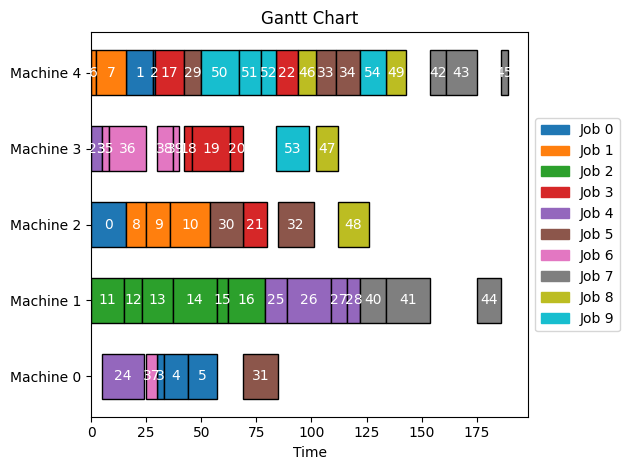

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [30]:
env.render(td, 0)
# Update plot within a for loop
while not td["done"].all():
    # Clear the previous output for the next iteration
    clear_output(wait=True)

    td = make_step(td)
    env.render(td, 0)
    # Display updated plot
    display(plt.gcf())
    
    # Pause for a moment to see the changes
    time.sleep(.4)

In [31]:
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 512
    train_data_size = 100_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 32
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

# Policy: neural network, in this case with encoder-decoder architecture
policy = HetGNNPolicy(embed_dim=embed_dim, num_encoder_layers=num_encoder_layers, env_name="fjsp")

# Model: default is AM with REINFORCE and greedy rollout baseline
model = HetGNNModel(env, 
                    policy=policy, 
                    baseline="rollout",                        
                    batch_size=batch_size,
                    train_data_size=train_data_size,
                    val_data_size=1_000,
                    optimizer_kwargs={"lr": 1e-4})

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator=accelerator,
    devices=1,
    logger=None,
)

trainer.fit(model)

/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:556: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU a

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/RL/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2: 100%|██████████| 32/32 [02:08<00:00,  0.25it/s, v_num=1, train/reward=-127., train/loss=33.30, val/reward=-128.]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 32/32 [02:20<00:00,  0.23it/s, v_num=1, train/reward=-127., train/loss=33.30, val/reward=-128.]


Best schedule: [[4, 2, 0, 0, 2, 3], [2, 0, 4, 1, 3], [0, 4, 4, 1, 4], [2, 2, 0, 4, 4, 0], [0, 1, 1, 1, 1, 4], [4, 1, 1, 3, 0, 4], [1, 1, 3, 2, 2, 0], [4, 1, 0, 2, 3, 3], [4, 1, 2, 2, 0], [0, 3, 4, 3, 4, 2]]
Best makespan: 382


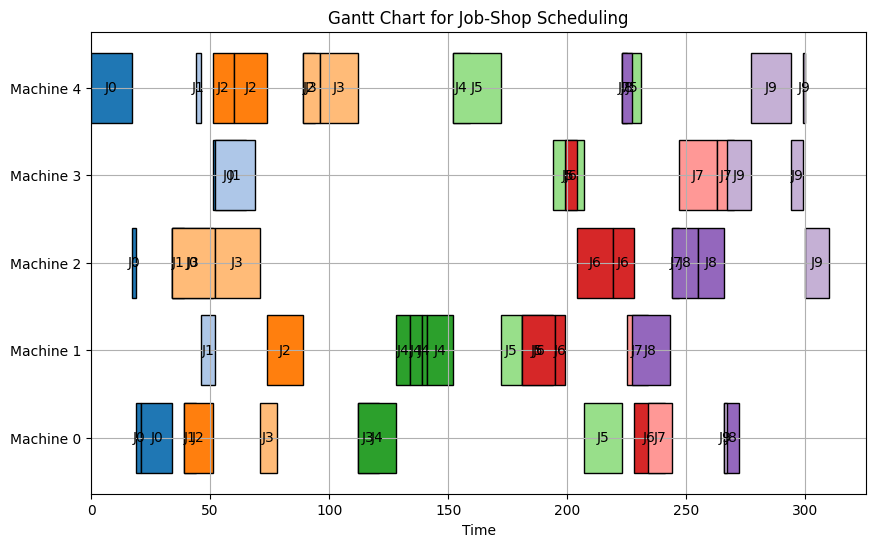

In [33]:
import random
import matplotlib.pyplot as plt
import numpy as np

# 환경 설정
generator_params = {
    "num_jobs": 10,  # 작업의 총 수
    "num_machines": 5,  # 작업을 처리할 수 있는 기계의 총 수
    "min_ops_per_job": 4,  # 작업당 최소 작업 단계 수
    "max_ops_per_job": 6,  # 작업당 최대 작업 단계 수
    "min_processing_time": 1,  # 작업 단계를 처리하는 데 필요한 최소 시간
    "max_processing_time": 20,  # 작업 단계를 처리하는 데 필요한 최대 시간
    "min_eligible_ma_per_op": 1,  # 작업 단계를 처리할 수 있는 기계의 최소 수
    "max_eligible_ma_per_op": 5,  # 작업 단계를 처리할 수 있는 기계의 최대 수
}

# 작업 및 기계 초기화
num_jobs = generator_params["num_jobs"]
num_machines = generator_params["num_machines"]
min_ops_per_job = generator_params["min_ops_per_job"]
max_ops_per_job = generator_params["max_ops_per_job"]
min_processing_time = generator_params["min_processing_time"]
max_processing_time = generator_params["max_processing_time"]
min_eligible_ma_per_op = generator_params["min_eligible_ma_per_op"]
max_eligible_ma_per_op = generator_params["max_eligible_ma_per_op"]

jobs = []
for job_id in range(num_jobs):
    num_ops = random.randint(min_ops_per_job, max_ops_per_job)
    operations = []
    for op_id in range(num_ops):
        processing_time = random.randint(min_processing_time, max_processing_time)
        eligible_machines = random.sample(range(num_machines), random.randint(min_eligible_ma_per_op, max_eligible_ma_per_op))
        operations.append((processing_time, eligible_machines))
    jobs.append(operations)

# 유전자 알고리즘 파라미터
population_size = 50
num_generations = 100
mutation_rate = 0.1
crossover_rate = 0.8

# 초기화
def initialize_population():
    population = []
    for _ in range(population_size):
        individual = []
        for job in jobs:
            job_schedule = []
            for op in job:
                machine = random.choice(op[1])
                job_schedule.append(machine)
            individual.append(job_schedule)
        population.append(individual)
    return population

# 적합도 평가
def calculate_fitness(individual):
    machine_time = [0] * num_machines
    job_end_time = [0] * num_jobs
    
    for job_id, job_schedule in enumerate(individual):
        job_start_time = 0
        for op_id, machine in enumerate(job_schedule):
            processing_time = jobs[job_id][op_id][0]
            start_time = max(machine_time[machine], job_start_time)
            end_time = start_time + processing_time
            machine_time[machine] = end_time
            job_start_time = end_time
        job_end_time[job_id] = job_start_time
    
    return max(job_end_time)

# 선택
def select(population, fitnesses):
    selected_indices = random.choices(range(population_size), weights=fitnesses, k=population_size)
    return [population[i] for i in selected_indices]

# 교차
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, len(parent1) - 2)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    return parent1, parent2

# 돌연변이
def mutate(individual):
    for job_schedule in individual:
        if random.random() < mutation_rate:
            op_id = random.randint(0, len(job_schedule) - 1)
            job_schedule[op_id] = random.choice(jobs[individual.index(job_schedule)][op_id][1])
    return individual

# 메인 알고리즘
population = initialize_population()
for generation in range(num_generations):
    fitnesses = [1 / calculate_fitness(ind) for ind in population]
    population = select(population, fitnesses)
    
    next_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = population[i], population[i + 1]
        child1, child2 = crossover(parent1, parent2)
        next_population.append(mutate(child1))
        next_population.append(mutate(child2))
    
    population = next_population

# 최적해 찾기
best_individual = min(population, key=calculate_fitness)
best_fitness = calculate_fitness(best_individual)

print("Best schedule:", best_individual)
print("Best makespan:", best_fitness)

# Gantt 차트 생성
machine_schedule = [[] for _ in range(num_machines)]
for job_id, job_schedule in enumerate(best_individual):
    job_start_time = 0
    for op_id, machine in enumerate(job_schedule):
        processing_time = jobs[job_id][op_id][0]
        start_time = max(job_start_time, machine_schedule[machine][-1][1] if machine_schedule[machine] else 0)
        end_time = start_time + processing_time
        machine_schedule[machine].append((job_id, start_time, end_time))
        job_start_time = end_time

# Gantt 차트 시각화
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab20(range(num_jobs))

for machine_id, tasks in enumerate(machine_schedule):
    for task in tasks:
        job_id, start_time, end_time = task
        ax.barh(machine_id, end_time - start_time, left=start_time, color=colors[job_id], edgecolor='black')
        ax.text(start_time + (end_time - start_time) / 2, machine_id, f'J{job_id}', va='center', ha='center', color='black')

ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {i}' for i in range(num_machines)])
ax.set_xlabel('Time')
ax.set_title('Gantt Chart for Job-Shop Scheduling')
plt.grid(True)
plt.show()